<h6> Problem statement : </h6>
<p> Classify the given genetic variations based on evidence from text-based clinical literature. </p>

<h3> Performance Metric</h3>

Metric(s): 
* Multi class log-loss 
* Confusion matrix 

# Import Necessary Library's

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

E:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Reading Data

In [2]:
data = pd.read_csv('training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
# reading text data
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# Preprocessing of text

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [6]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 40.60818280000012 seconds


In [7]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [8]:
#printing null 
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [9]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

<h6> Adding new features to the dataset: </h6>

1. text_len = length of the complete text,
2. text_count = number of words in the text.
3. text_density = text_len/text_count

In [10]:
result["text_len"] = result['TEXT'].apply(len)
result['text_count'] = result['TEXT'].apply(lambda x: len(x.split()))
result['text_density'] = result['text_len'] / (result['text_count']+1)

In [11]:
result.head()

,ID,Gene,Variation,Class,TEXT,text_len,text_count,text_density
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...,30836,4370,7.054679
1,1,CBL,W802*,2,abstract background non small cell lung cancer...,27844,4139,6.725604
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...,27844,4139,6.725604
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,28093,3841,7.312077
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...,31649,4254,7.438073


# Test, Train and Cross Validation Split

In [12]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [13]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


# Distribution of y_i's in Train, Test and Cross Validation datasets

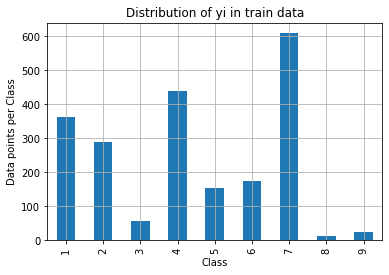

--------------------------------------------------------------------------------


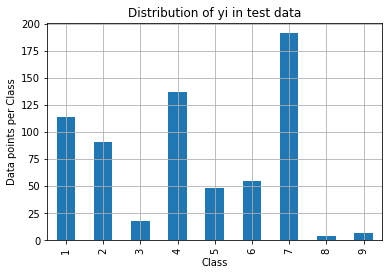

--------------------------------------------------------------------------------


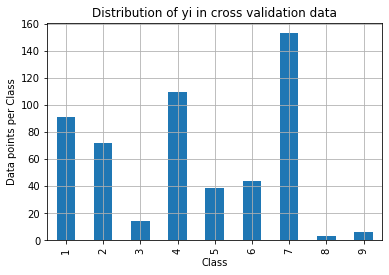

In [14]:
# it returns a dict, keys as class labels and values as the number of data points in that class
list_train_df = train_df['Class'].tolist()
list_test_df = test_df['Class'].tolist()
list_cv_df = cv_df['Class'].tolist()

train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()



<h6> Insights: </h6>
 In all three train, test and cv data class with labels (1,2,4,7) have mojority of datapoints.

# Prediction Using Random Model

In [15]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.471981468520727
Log loss on Test Data using Random Model 2.4835944937296373
-------------------- Confusion matrix --------------------


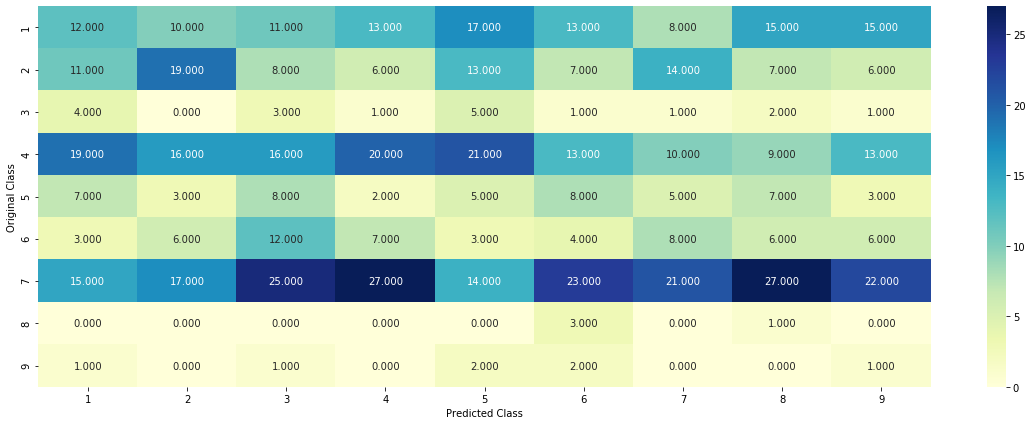

-------------------- Precision matrix (Columm Sum=1) --------------------


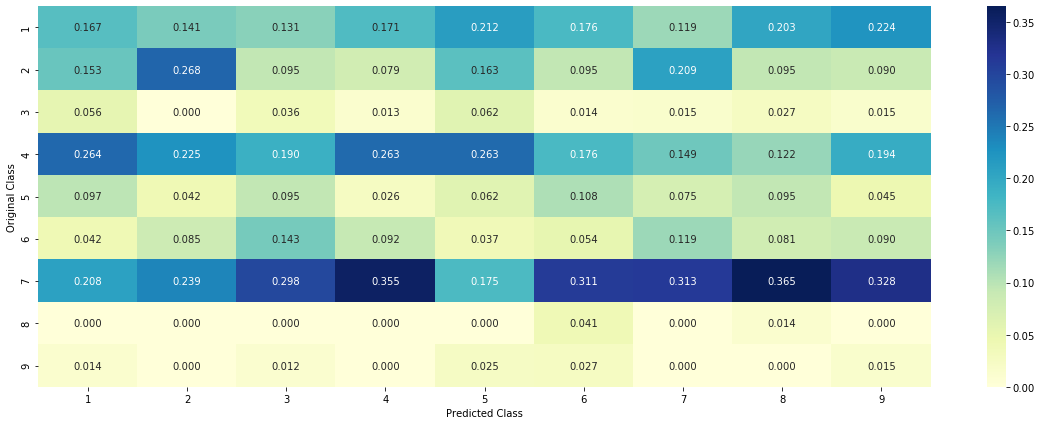

-------------------- Recall matrix (Row sum=1) --------------------


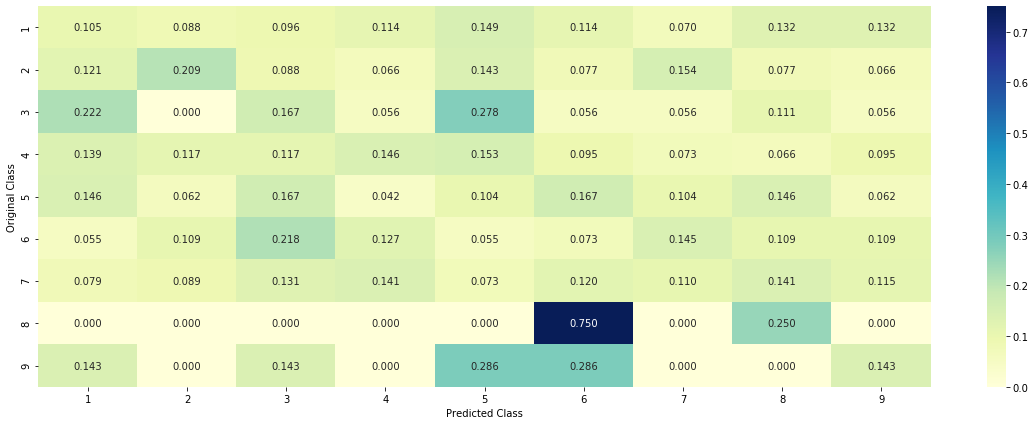

In [16]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

Random Model will not work for this model because of high log loss value.

# Univariate Analysis

In [17]:
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    for i, denominator in value_count.items():
        vec = []
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

# Gene Feature

In [18]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 224
BRCA1     159
TP53      107
EGFR       98
BRCA2      82
PTEN       75
KIT        66
BRAF       59
ALK        43
ERBB2      42
PDGFRA     41
Name: Gene, dtype: int64


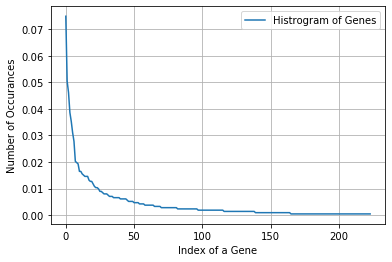

In [19]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


there are only 20 to 25 gene that have most occurance 

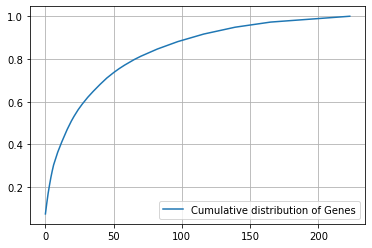

In [20]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

Almost 75% of gene feature are under 50 unique feature

In [21]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

For values of alpha =  1e-05 The log loss is: 1.1915284784622535
For values of alpha =  0.0001 The log loss is: 1.1706241085764815
For values of alpha =  0.001 The log loss is: 1.2126256539403828
For values of alpha =  0.01 The log loss is: 1.328018446751767
For values of alpha =  0.1 The log loss is: 1.4379971584015971
For values of alpha =  1 The log loss is: 1.4695948719962013


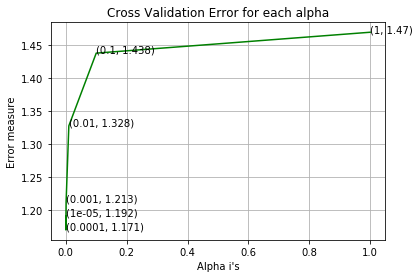

For values of best alpha =  0.0001 The train log loss is: 1.0130983124067594
For values of best alpha =  0.0001 The cross validation log loss is: 1.1706241085764815
For values of best alpha =  0.0001 The test log loss is: 1.1531780770188131


In [22]:
#building a simple ML model to check how good is this gene feature in predicting y_i
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [23]:
print("Q1. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q1. How many data points in Test and CV datasets are covered by the  224  genes in train dataset?
Ans
1. In test data 639 out of 665 : 96.09022556390977
2. In cross validation data 509 out of  532 : 95.67669172932331


OBSERVATION:
1) clearly we can see that log loss for all train,test and cv of gene feature is very less than the our random model log loss 
   so it is useful.
   
2) it is a stable feature too as almost all points of cv and test data are overlapping with train data.

# Univariate Analysis using Occurrance of Gene Feature

In [117]:
train_df.Gene.value_counts().sort_values(ascending=False).head()

BRCA1    159
TP53     107
EGFR      98
BRCA2     82
PTEN      75
Name: Gene, dtype: int64

In [25]:
# make a list with most frequent categories of a variable

top200 = [x for x in train_df.Gene.value_counts().sort_values(ascending=False).head(200).index]

In [26]:
# now make  binary variables
for label in top200:
    train_df[label] = np.where(train_df['Gene']==label,1,0)
    

In [27]:
train_df[['Gene']+top200]

,Gene,BRCA1,TP53,EGFR,BRCA2,PTEN,KIT,BRAF,ALK,ERBB2,...,INPP4B,CDK4,H3F3A,SMARCB1,FAM58A,ARID5B,KMT2B,SDHC,BTK,BCL10
2784,BRCA2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010,MAP2K1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3022,KIT,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2349,JAK2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2726,BRAF,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,BRCA1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433,SPOP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2163,PTEN,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1821,RHOA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# now make  binary variables
for label in top200:
    test_df[label] = np.where(test_df['Gene']==label,1,0)
    

In [29]:
test_df[['Gene']+top200]

,Gene,BRCA1,TP53,EGFR,BRCA2,PTEN,KIT,BRAF,ALK,ERBB2,...,INPP4B,CDK4,H3F3A,SMARCB1,FAM58A,ARID5B,KMT2B,SDHC,BTK,BCL10
231,EGFR,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2265,PTEN,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
713,ERBB2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
871,PDGFRA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
708,ERBB2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,SPOP,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2802,BRCA2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2882,BRCA2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2702,BRAF,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# now make  binary variables
for label in top200:
    cv_df[label] = np.where(cv_df['Gene']==label,1,0)


In [31]:
cv_df[['Gene']+top200]

,Gene,BRCA1,TP53,EGFR,BRCA2,PTEN,KIT,BRAF,ALK,ERBB2,...,INPP4B,CDK4,H3F3A,SMARCB1,FAM58A,ARID5B,KMT2B,SDHC,BTK,BCL10
902,PDGFRA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1352,AKT1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1841,SETD2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2145,KEAP1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2881,BRCA2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,TP53,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2601,BRCA1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2450,BRCA1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420,TP53,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
dd = train_df
cc = cv_df
tt = test_df

In [33]:
train_g = dd.drop(['ID', 'Gene', 'Variation', 'Class', 'TEXT','text_len', 'text_count', 'text_density'], axis=1)
test_g = tt.drop([ 'ID','Gene', 'Variation', 'Class', 'TEXT','text_len', 'text_count', 'text_density'], axis=1)
cv_g = cc.drop(['ID','Gene', 'Variation', 'Class', 'TEXT','text_len', 'text_count', 'text_density'], axis=1)

For values of alpha =  1e-05 The log loss is: 1.191317968398258
For values of alpha =  0.0001 The log loss is: 1.169184084653754
For values of alpha =  0.001 The log loss is: 1.2144915134611607
For values of alpha =  0.01 The log loss is: 1.3198234430865199
For values of alpha =  0.1 The log loss is: 1.3659291615833098
For values of alpha =  1 The log loss is: 1.3782311359733666


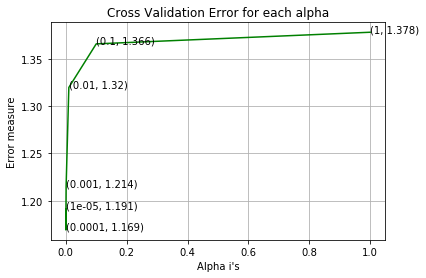

For values of best alpha =  0.0001 The train log loss is: 1.0240511579419926
For values of best alpha =  0.0001 The cross validation log loss is: 1.169184084653754
For values of best alpha =  0.0001 The test log loss is: 1.15934013303726


In [34]:
# dataframe
alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_g, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_g, y_train)
    predict_y = sig_clf.predict_proba(cv_g)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_g, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_g, y_train)

predict_y = sig_clf.predict_proba(train_g)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_g)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_g)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Variation Feature

In [35]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1933
Truncating_Mutations    60
Deletion                49
Amplification           43
Fusions                 22
Q61R                     3
Overexpression           3
Q61L                     3
I31M                     2
E330K                    2
Y64A                     2
Name: Variation, dtype: int64


In [36]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1933
Truncating_Mutations    60
Deletion                49
Amplification           43
Fusions                 22
Q61R                     3
Overexpression           3
Q61L                     3
I31M                     2
E330K                    2
Y64A                     2
Name: Variation, dtype: int64


In [37]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1933
Truncating_Mutations    60
Deletion                49
Amplification           43
Fusions                 22
Q61R                     3
Overexpression           3
Q61L                     3
I31M                     2
E330K                    2
Y64A                     2
Name: Variation, dtype: int64


In [38]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

For values of alpha =  1e-05 The log loss is: 1.7158978123222555
For values of alpha =  0.0001 The log loss is: 1.7067533303970117
For values of alpha =  0.001 The log loss is: 1.7100002678280277
For values of alpha =  0.01 The log loss is: 1.7204309915143028
For values of alpha =  0.1 The log loss is: 1.734129882511976
For values of alpha =  1 The log loss is: 1.7349725525771915


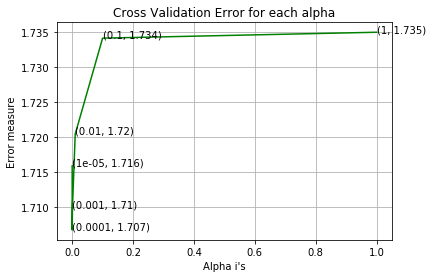

For values of best alpha =  0.0001 The train log loss is: 0.6676320678409959
For values of best alpha =  0.0001 The cross validation log loss is: 1.7067533303970117
For values of best alpha =  0.0001 The test log loss is: 1.7088161969929667


In [39]:
# checking how good is this Variation feature in predicting y_i?
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [40]:
print("Q2. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q2. How many data points are covered by total  1933  genes in test and cross validation data sets?
Ans
1. In test data 74 out of 665 : 11.12781954887218
2. In cross validation data 55 out of  532 : 10.338345864661653


OBSERVATION:

1) although this feature has log loss less than random model log loss but due large differnce in train and cv log loss there 
   might be chaces of overfitting
    
2) it is not stable across all datasets

# Univariate Analysis using Occurrance of Variation Feature

In [116]:
train_df.Variation.value_counts().sort_values(ascending=False).head()

Truncating_Mutations    60
Deletion                49
Amplification           43
Fusions                 22
Q61R                     3
Name: Variation, dtype: int64

In [42]:
# make a list with most frequent categories of a variable

top400 = [x for x in train_df.Variation.value_counts().sort_values(ascending=False).head(400).index]

In [43]:
# now make  binary variables
for label in top400:
    train_df[label] = np.where(train_df['Variation']==label,1,0)


In [44]:
train_df[['Variation']+top400]

,Variation,Truncating_Mutations,Deletion,Amplification,Fusions,Q61R,Overexpression,Q61L,Q61H,R841K,...,T131L,MAGI3-AKT3_Fusion,G266R,V1653M,L617F,W1837R,H697Y,A500T,P316L,V277D
2784,R2418G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010,F53L,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3022,A502_Y503dup,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2349,R683K,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2726,D594G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,R170W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1433,R121Q,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2163,G129R,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1821,E40L,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# now make  binary variables
for label in top400:
    test_df[label] = np.where(test_df['Variation']==label,1,0)


In [46]:
test_df[['Variation']+top400]

,Variation,Truncating_Mutations,Deletion,Amplification,Fusions,Q61R,Overexpression,Q61L,Q61H,R841K,...,T131L,MAGI3-AKT3_Fusion,G266R,V1653M,L617F,W1837R,H697Y,A500T,P316L,V277D
231,E746_A750delinsQ,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2265,H93R,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
713,I767M,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
871,C450_K451insMIEWMI,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
708,V659E,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,F133L,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2802,N2436I,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2882,D2723G,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2702,T529I,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# now make  binary variables
for label in top400:
    cv_df[label] = np.where(cv_df['Variation']==label,1,0)

In [48]:
cv_df[['Variation']+top400]

,Variation,Truncating_Mutations,Deletion,Amplification,Fusions,Q61R,Overexpression,Q61L,Q61H,R841K,...,T131L,MAGI3-AKT3_Fusion,G266R,V1653M,L617F,W1837R,H697Y,A500T,P316L,V277D
902,N659R,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1352,G311D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1841,R1625C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2145,G333S,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2881,A2770T,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,I251S,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2601,M1400V,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2450,S72R,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
420,H179Y,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
d = train_df
c = cv_df
t = test_df

In [50]:
train_v = d.drop(['ID', 'Gene', 'Variation', 'Class', 'TEXT','text_len', 'text_count', 'text_density'], axis=1)
test_v = t.drop(['ID', 'Gene', 'Variation', 'Class', 'TEXT','text_len', 'text_count', 'text_density'], axis=1)
cv_v = c.drop(['ID', 'Gene', 'Variation', 'Class', 'TEXT','text_len', 'text_count', 'text_density'], axis=1)

For values of alpha =  1e-05 The log loss is: 1.1330575804624499
For values of alpha =  0.0001 The log loss is: 1.1001390792918664
For values of alpha =  0.001 The log loss is: 1.142810095019392
For values of alpha =  0.01 The log loss is: 1.2380226388224342
For values of alpha =  0.1 The log loss is: 1.2812362339212648
For values of alpha =  1 The log loss is: 1.2911513309689722


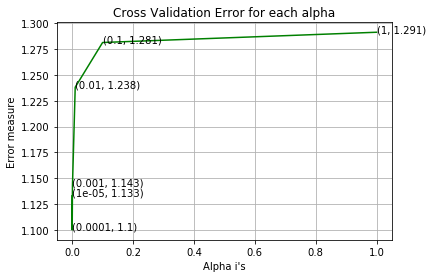

For values of best alpha =  0.0001 The train log loss is: 0.8598833826714346
For values of best alpha =  0.0001 The cross validation log loss is: 1.1001390792918664
For values of best alpha =  0.0001 The test log loss is: 1.0886717195851616


In [51]:
# checking how good is this Variation feature in predicting y_i?

alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_v, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_v, y_train)
    predict_y = sig_clf.predict_proba(cv_v)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_v, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_v, y_train)

predict_y = sig_clf.predict_proba(train_v)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_v)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_v)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# Text Feature Analysis

In [52]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [53]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [54]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = TfidfVectorizer(min_df=3,max_features=1000)
train_text_feature_tfidf = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_tfidf.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 1000


In [55]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


In [56]:
# don't forget to normalize every feature
train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_tfidf = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_tfidf = normalize(test_text_feature_tfidf, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_tfidf = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_tfidf = normalize(cv_text_feature_tfidf, axis=0)

In [57]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [58]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({254.9832246438016: 1, 179.7741939937498: 1, 133.00104330669197: 1, 132.39037062559473: 1, 128.396763136321: 1, 117.58872126051526: 1, 114.92226959630078: 1, 114.6019590568891: 1, 111.12264083452128: 1, 105.94541643610273: 1, 104.85395985828075: 1, 90.39276864465825: 1, 90.19957156586021: 1, 86.24940775516582: 1, 85.4396922363256: 1, 83.8521566915104: 1, 79.83601597219788: 1, 79.04790670254968: 1, 78.22661019458887: 1, 77.93006948651504: 1, 76.19588981539502: 1, 75.64319419785927: 1, 71.59953915336972: 1, 70.98348167557918: 1, 69.05420083197143: 1, 68.1893915368868: 1, 68.07811567571362: 1, 66.2382604525407: 1, 64.35222256224166: 1, 63.893405038068835: 1, 63.57491355410851: 1, 63.56979149912506: 1, 63.05917453167975: 1, 59.70169396159152: 1, 58.64418071096876: 1, 58.074198459339826: 1, 56.516378382915896: 1, 56.07719159342609: 1, 55.97551633189366: 1, 51.01712355361044: 1, 50.57438733201311: 1, 49.22415969348195: 1, 48.69714018466204: 1, 48.60403527269292: 1, 47.49957941389276:

For values of alpha =  1e-05 The log loss is: 1.1549729772933957
For values of alpha =  0.0001 The log loss is: 1.152038176406531
For values of alpha =  0.001 The log loss is: 1.363217165896946
For values of alpha =  0.01 The log loss is: 1.8622365423535456
For values of alpha =  0.1 The log loss is: 2.0023886965829583
For values of alpha =  1 The log loss is: 1.9927160992168143


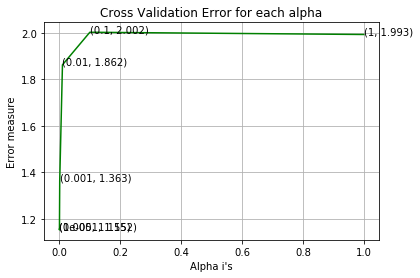

For values of best alpha =  0.0001 The train log loss is: 0.8186982331429766
For values of best alpha =  0.0001 The cross validation log loss is: 1.152038176406531
For values of best alpha =  0.0001 The test log loss is: 1.0839754990238155


In [59]:
# Train a Logistic regression+Calibration model using text features which are on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_tfidf, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_tfidf, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_tfidf)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_tfidf, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [60]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [61]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

3.406 % of word of test data appeared in train data
4.063 % of word of Cross Validation appeared in train data


# Featuring Engineering on Text data 

In [62]:
data = X_train["TEXT"]

In [63]:
vectorizer = TfidfVectorizer()
text_tfidf = vectorizer.fit_transform(data)
print("Shape of matrix: ",text_tfidf.shape)

Shape of matrix:  (2656, 138405)


In [64]:
text_tfidf = vectorizer.idf_
text_tfidf

array([2.86635973, 1.580437  , 7.09319348, ..., 8.19180577, 8.19180577,
       8.19180577])

In [65]:
vec = vectorizer.get_feature_names()

In [66]:
arr=[]
for i in range(len(text_tfidf)):
    arr.append([text_tfidf[i],vec[i]])

In [67]:
arr = sorted(arr, key = lambda x : x, reverse = True)[:500] 

In [115]:
#top 500 
car =[]
for i in range(len(arr)):
    car.append(arr[i][1])

In [113]:
#main data
data = list(data)

In [70]:
#for main data
def GetContext1(sentence, index):
    words = sentence.split(' ')
    ret=[]
    for word in words:

        if index==0:
            ret.append(words[index+1])
            ret.append(words[index+2])
        elif index==1:
            ret.append(words[index-1])
            ret.append(words[index+1])
            ret.append(words[index+2])
        elif index==(len(words)-1):
            ret.append(words[index-2])
            ret.append(words[index-1])
        elif index==(len(words)-2):
            ret.append(words[index-2])
            ret.append(words[index-1])
            ret.append(words[index+1])
        else:
            ret.append(words[index-2])
            ret.append(words[index-1])
            ret.append(words[index+1])
            ret.append(words[index+2])
        return ret     

In [71]:
#for main file
CORPUS= data
top500 = car
a = np.zeros((500,500), np.int64)
for  sentence in CORPUS:
    for index,word in enumerate(sentence.split(' ')):
        if word in top500:
            print(index)
            context=GetContext1(sentence,index)
            print(context)
            for word2 in context:
                if word2 in top500:
                    a[top500.index(word)][top500.index(word2)]+=1
#for i in range(2000):
 #   a[i][i] = 0                    
print(a)

770
['domain', 'multiple', 'motifs', '11a']
5328
['transfected', 'cos', 'also', 'conserved']
3085
['factors', 'including', 'hlf', 'hmga2']
8933
['fingers', 'zf1', 'remain', 'truncated']
3482
['al', '2009', 'et', 'al']
17807
['patients', 'bannayan', 'syndrome', 'cowden']
3293
['known', 'vandetanib', 'phosphorylation', 'ret']
8549
['john', 'myseros27', 'dong28', 'peter']
748
['yf', 'p', 'py589', 'py591']
758
['ye', 'p', 'wef', 'py597']
1293
['ctgssdne', 'p', 'y599', 'cyvdfreyeydlkwef']
1306
['freye', 'p', 'control', 'specificity']
1323
['ne', 'p', 'peptides', 'dissolved']
2488
['signaling', 'pathways', 'et', 'al']
20006
['mouse', 'lungs', 'et', 'al']
2539
['keyan', 'road', 'miaoli', '35053']
556
['address', 'department', 'university', 'washington']
12602
['calls', 'ceu', 'populations', '1000']
1624
['4', '81', '2', '2']
2842
['y637', 'sequence', 'r', 'k']
6513
['cytokine', 'receptors', 'preceded', 'acid']
5249
['dr', 'toshihiko', 'http', 'www']
530
['tsc1', 'pombe', 'contains', '899']
55

6426
['growing', 'oocytes', 'cre', 'resulted']
358
['localization', 'catenin', 'nishikawa1', 'tatsuhiko']
369
['4', 'hidehisa', 'mayumi', 'isokane1']
539
['rat', 'myeloma', '0', 'cells']
918
['performed', 'using', 'alexa', 'fluor']
6930
['s1', 'using', 'zymoresearch', 'indicated']
6931
['using', 'zymotaq', 'indicated', 'temperatures']
2598
['systems', 'analysis', 'centre', 'biological']
1255
['axl', 'y696', 'mitogenic', 'receptor']
6000
['homologous', 'positions', 'showed', '50']
6261
['families', '58', '45', 'years']
1355
['gif', 'sur', 'cellular', 'viability']
23149
['genbank', 'accession', '17', 'position']
25697
['sr', 'wang', 'et', 'al']
26558
['1999', 'shtutman', 'j', 'simcha']
33327
['3', 'additionally', 'al', '55']
34876
['also', 'called', 'sourisseau', 'et']
5344
['001202554nm', '032283', '2', '28']
37667
['homologous', 'tyrosines', '591', 'resulted']
2513
['myoepithelium', '40', 'et', 'al']
2739
['q12', 'ewsr1', 'patz1', '22']
2855
['active', 'ews', 'fusion', 'gene']
8405
['a

924
['methylation', 'environments', 'et', 'al']
6100
['extract', '30', 'protein', 'cells']
8218
['primer', 'method', 'smith', '1984']
9026
['contained', '2', '0', '44']
1269
['provided', 'k', 'hiroshima', 'university']
2100
['medical', 'sciences', 'et', 'al']
2106
['medical', 'sciences', 'et', 'al']
3676
['including', 'arid1b', 'individual', 'global']
3795
['contains', 'arid1b', 'tmem242', 'individual']
4801
['deletion', 'arid1b', 'tmem242', '17']
565
['mutant', 'g13d', 'yescd', 'nb4']
566
['g13d', 'yescd', 'nb4', 'mutant']
570
['mutant', 'a18d', 'yesd', 'skm']
571
['a18d', 'yesd', 'skm', '1']
576
['mutant', 'k117n', 'yesd', 'mono']
577
['k117n', 'yesd', 'mono', 'mac']
608
['mutant', 'g12a', 'yesd', 'mm']
609
['g12a', 'yesd', 'mm', '1s']
623
['mutant', 'g13d', 'yescef', 'mda']
624
['g13d', 'yescef', 'mda', 'mb']
643
['mutant', 'g13d', 'yescef', 'hct']
644
['g13d', 'yescef', 'hct', '116a']
650
['g13d', 'noc', 'yesce', 'sw']
651
['noc', 'yese', 'sw', '480']
656
['mutant', 'g12v', 'yesef'

7030
['r', 'benlevi', 'unpublished', 'data']
602
['renmin', 'hospital', 'medical', 'college']
1650
['protein', 'known', 'belonging', 'protein']
4148
['xpln', 'pronounced', 'exchange', 'factor']
17519
['mutations', 'affect', 'cysteine', 'residues']
12721
['wings', 'cirillo', '2007', 'gajiwala']
964
['particles', 'ods', '5', '10']
994
['particles', 'ods', '5', '120']
678
['pcr', 'west', 'plus', 'western']
1639
['visualized', 'west', 'intron', 'biotec']
2410
['growth', 'factor', 'linde', '2000']
817
['dr', 'katherine', '37', 'tie2']
402
['615095', 'mutated', 'mim', '610827']
8660
['scanner', 'nano', 'hamamatsu', 'photonics']
6285
['also', 'known', '44', 'slc45a3']
3056
['akt', 'pathways', 'et', 'al']
1556
['y842d', 'y842h', 'view', 'inlineview']
1944
['flt3', 'itd', 'whereas', '300']
1195
['ala126thr', 'rs61758784', '15', '5']
1220
['p', 'val169ala', '1', '1']
1280
['p', 'gly264ser', '8', '2']
1295
['thr287ala', 'rs28363317', '14', '5']
1317
['p', 'rs45511291', '2', '1']
1328
['64c', 'p',

# Applying Truncated SVD

In [72]:
from sklearn.decomposition import TruncatedSVD
n_components = [50,55,60,65,80,100]
explained_variance= []
for n in n_components:
    svd = TruncatedSVD(n_components = n, random_state=42)
    svd.fit_transform(a)
    exvar=svd.explained_variance_ratio_.sum()
    explained_variance.append(exvar)
    
    print('n_components = ',n,'varience =',exvar)

n_components =  50 varience = 1.0000000000000042
n_components =  55 varience = 1.0000000000000004
n_components =  60 varience = 0.9999999999999996
n_components =  65 varience = 0.9999999999999991
n_components =  80 varience = 0.9999999999999976
n_components =  100 varience = 0.9999999999999989


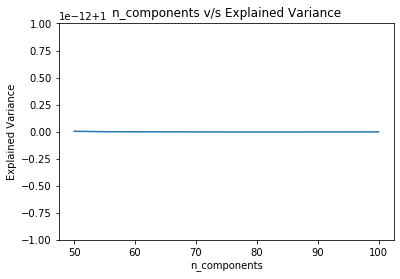

In [73]:
plt.plot(n_components,explained_variance)
plt.xlabel('n_components')
plt.ylabel('Explained Variance')
plt.title('n_components v/s Explained Variance')
plt.show()

In [112]:
from sklearn.decomposition import TruncatedSVD
explained_variance= []
for n in n_components:
    svd = TruncatedSVD(n_components = 65, random_state=42)
    final_matrix = svd.fit_transform(a)
    exvar=svd.explained_variance_ratio_.sum()
    explained_variance.append(exvar)
    

# vectorizing data by avg-w

In [75]:
model = {}
for i in range(0,500):
    model[top500[i]] = final_matrix[i]
glove_words = set(model.keys())

In [76]:
x_train_w2v = []; 
for sentence in tqdm(X_train['TEXT'].values):
    vector = np.zeros((65))
    cnt_words =0;
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    x_train_w2v.append(vector)


100%|█████████████████████████████████████████████████████████████████████████████| 2656/2656 [00:04<00:00, 648.27it/s]


In [77]:
train_df_w2v = []; 
for sentence in tqdm(train_df['TEXT'].values):
    vector = np.zeros((65))
    cnt_words =0;
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_df_w2v.append(vector)


100%|█████████████████████████████████████████████████████████████████████████████| 2124/2124 [00:03<00:00, 682.75it/s]


In [78]:
test_df_w2v = []; 
for sentence in tqdm(test_df['TEXT'].values):
    vector = np.zeros((65))
    cnt_words =0;
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_df_w2v.append(vector)


100%|███████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<00:00, 677.36it/s]


In [79]:
cv_df_w2v = []; 
for sentence in tqdm(cv_df['TEXT'].values):
    vector = np.zeros((65))
    cnt_words =0;
    for word in sentence.split(): 
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_df_w2v.append(vector)


100%|███████████████████████████████████████████████████████████████████████████████| 532/532 [00:00<00:00, 671.75it/s]


For values of alpha =  1e-05 The log loss is: 1.8303536059876555
For values of alpha =  0.0001 The log loss is: 1.8303536058839895
For values of alpha =  0.001 The log loss is: 1.8303536059419239
For values of alpha =  0.01 The log loss is: 1.8303536058757557
For values of alpha =  0.1 The log loss is: 1.8303536059359675
For values of alpha =  1 The log loss is: 1.8303536059648349


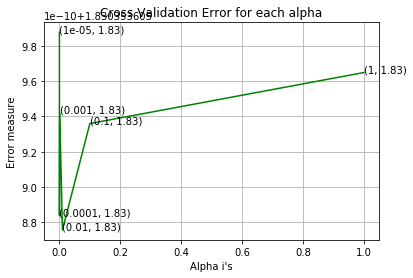

For values of best alpha =  0.01 The train log loss is: 1.8318581655276613
For values of best alpha =  0.01 The cross validation log loss is: 1.8303536058757557
For values of best alpha =  0.01 The test log loss is: 1.8306754082737702


In [80]:
# Train a Logistic regression+Calibration model using text features which are on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df_w2v, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df_w2v, y_train)
    predict_y = sig_clf.predict_proba(cv_df_w2v)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df_w2v, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df_w2v, y_train)

predict_y = sig_clf.predict_proba(train_df_w2v)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df_w2v)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df_w2v)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# TF-IDF Vectorizing

In [81]:
vectorizer2 = TfidfVectorizer(car)

In [82]:
vectorizer2.fit(train_df['TEXT'].values) # fit has to happen only on train data

#train _df
train_df_tfidf = vectorizer.transform(train_df['TEXT'].values)
#test _df
test_df_tfidf = vectorizer.transform(test_df['TEXT'].values)
#cv _df
cv_df_tfidf = vectorizer.transform(cv_df['TEXT'].values)

For values of alpha =  1e-05 The log loss is: 1.0584014600528857
For values of alpha =  0.0001 The log loss is: 1.0325138707382395
For values of alpha =  0.001 The log loss is: 1.1220039595748141
For values of alpha =  0.01 The log loss is: 1.3047964869628859
For values of alpha =  0.1 The log loss is: 1.5428194130116168
For values of alpha =  1 The log loss is: 1.6100794091168578


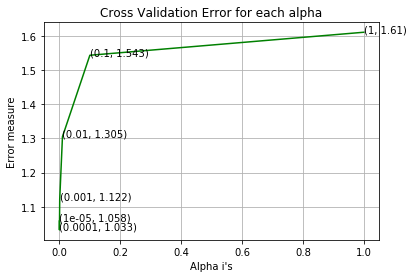

For values of best alpha =  0.0001 The train log loss is: 0.6571651475847607
For values of best alpha =  0.0001 The cross validation log loss is: 1.0325138707382395
For values of best alpha =  0.0001 The test log loss is: 0.9988160416256913


In [83]:
# Train a Logistic regression+Calibration model using text features which are on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df_tfidf, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df_tfidf, y_train)
    predict_y = sig_clf.predict_proba(cv_df_tfidf)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df_tfidf, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df_tfidf, y_train)

predict_y = sig_clf.predict_proba(train_df_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df_tfidf)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


# # Univariate Analysis on Text_count Feature 

In [84]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
train_text_count_norm = normalizer.fit_transform(train_df['text_count'].values.reshape(1,-1))
test_text_count_norm = normalizer.fit_transform(test_df['text_count'].values.reshape(1,-1))
cv_text_count_norm = normalizer.fit_transform(cv_df['text_count'].values.reshape(1,-1))

train_text_count_norm=train_text_count_norm.reshape(-1,1)
test_text_count_norm=test_text_count_norm.reshape(-1,1)
cv_text_count_norm=cv_text_count_norm.reshape(-1,1)


For values of alpha =  1e-05 The log loss is: 1.8241937871873073
For values of alpha =  0.0001 The log loss is: 1.8241937824672203
For values of alpha =  0.001 The log loss is: 1.8241937782230762
For values of alpha =  0.01 The log loss is: 1.8231426884218027
For values of alpha =  0.1 The log loss is: 1.8276464091621452
For values of alpha =  1 The log loss is: 1.8206612849875738


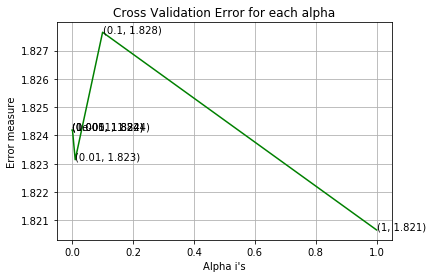

For values of best alpha =  1 The train log loss is: 1.811902999869933
For values of best alpha =  1 The cross validation log loss is: 1.8206612849875738
For values of best alpha =  1 The test log loss is: 1.8457040882807967


In [85]:
# checking how good is this Variation feature in predicting y_i?
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_count_norm, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_count_norm, y_train)
    predict_y = sig_clf.predict_proba(cv_text_count_norm)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_count_norm, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_count_norm, y_train)

predict_y = sig_clf.predict_proba(train_text_count_norm)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_count_norm)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_count_norm)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [86]:
print("Q. How many data points in Test and CV datasets are covered by the genes in train dataset?")

test_coverage=test_df[test_df['text_count'].isin(list(set(train_df['text_count'])))].shape[0]
cv_coverage=cv_df[cv_df['text_count'].isin(list(set(train_df['text_count'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q. How many data points in Test and CV datasets are covered by the genes in train dataset?
Ans
1. In test data 366 out of 665 : 55.037593984962406
2. In cross validation data 275 out of  532 : 51.691729323308266


OBSERVATION:

1. clearly we can see that log loss for all train,test and cv of gene feature is very less than the our random model log loss so it is useful

2. it is a stable feature too as almost half-of points of cv and test data are overlapping with train data

#  Univariate Analysis on Text_len Feature 

In [87]:
normalizer = Normalizer()
train_text_len_norm = normalizer.fit_transform(train_df['text_len'].values.reshape(1,-1))
test_text_len_norm = normalizer.fit_transform(test_df['text_len'].values.reshape(1,-1))
cv_text_len_norm = normalizer.fit_transform(cv_df['text_len'].values.reshape(1,-1))

train_text_len_norm=train_text_len_norm.reshape(-1,1)
test_text_len_norm=test_text_len_norm.reshape(-1,1)
cv_text_len_norm=cv_text_len_norm.reshape(-1,1)


For values of alpha =  1e-05 The log loss is: 1.8255674995270041
For values of alpha =  0.0001 The log loss is: 1.8255674852059574
For values of alpha =  0.001 The log loss is: 1.8255675259778847
For values of alpha =  0.01 The log loss is: 1.824420669450899
For values of alpha =  0.1 The log loss is: 1.8288441792634118
For values of alpha =  1 The log loss is: 1.8254020306831207


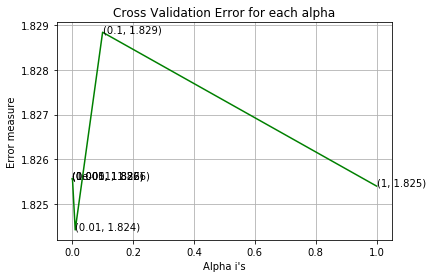

For values of best alpha =  0.01 The train log loss is: 1.8106927634671066
For values of best alpha =  0.01 The cross validation log loss is: 1.824420669450899
For values of best alpha =  0.01 The test log loss is: 1.8497901770016703


In [88]:
# checking how good is this Variation feature in predicting y_i?
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_len_norm, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_len_norm, y_train)
    predict_y = sig_clf.predict_proba(cv_text_len_norm)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_len_norm, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_len_norm, y_train)

predict_y = sig_clf.predict_proba(train_text_len_norm)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_len_norm)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_len_norm)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [89]:
print("Q. How many data points in Test and CV datasets are covered by the " " genes in train dataset?")

test_coverage=test_df[test_df['text_len'].isin(list(set(train_df['text_len'])))].shape[0]
cv_coverage=cv_df[cv_df['text_len'].isin(list(set(train_df['text_len'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q. How many data points in Test and CV datasets are covered by the  genes in train dataset?
Ans
1. In test data 350 out of 665 : 52.63157894736842
2. In cross validation data 251 out of  532 : 47.18045112781955


#  Univariate Analysis on Text_density Feature 

In [90]:
normalizer = Normalizer()
train_text_den_norm = normalizer.fit_transform(train_df['text_density'].values.reshape(1,-1))
test_text_den_norm = normalizer.fit_transform(test_df['text_density'].values.reshape(1,-1))
cv_text_den_norm = normalizer.fit_transform(cv_df['text_density'].values.reshape(1,-1))

train_text_den_norm=train_text_den_norm.reshape(-1,1)
test_text_den_norm=test_text_den_norm.reshape(-1,1)
cv_text_den_norm=cv_text_den_norm.reshape(-1,1)


For values of alpha =  1e-05 The log loss is: 2.3023129267266675
For values of alpha =  0.0001 The log loss is: 2.2294389612947363
For values of alpha =  0.001 The log loss is: 2.0818315391694524
For values of alpha =  0.01 The log loss is: 1.8450703239994017
For values of alpha =  0.1 The log loss is: 1.8303581548773447
For values of alpha =  1 The log loss is: 1.8359730216050647


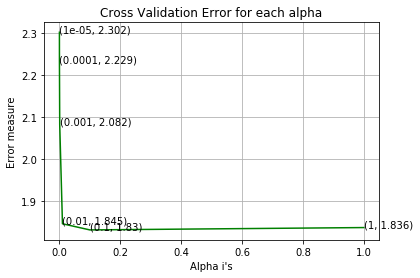

For values of best alpha =  0.1 The train log loss is: 1.8318579032026099
For values of best alpha =  0.1 The cross validation log loss is: 1.8303581548773447
For values of best alpha =  0.1 The test log loss is: 1.8306644167371215


In [91]:
# checking how good is this Variation feature in predicting y_i?
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_den_norm, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_den_norm, y_train)
    predict_y = sig_clf.predict_proba(cv_text_den_norm)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_den_norm, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_den_norm, y_train)

predict_y = sig_clf.predict_proba(train_text_den_norm)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_den_norm)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_den_norm)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [92]:
print("Q. How many data points in Test and CV datasets are covered by the " " genes in train dataset?")

test_coverage=test_df[test_df['text_density'].isin(list(set(train_df['text_density'])))].shape[0]
cv_coverage=cv_df[cv_df['text_density'].isin(list(set(train_df['text_density'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q. How many data points in Test and CV datasets are covered by the  genes in train dataset?
Ans
1. In test data 343 out of 665 : 51.578947368421055
2. In cross validation data 245 out of  532 : 46.05263157894737


# Apply hstack for Module

In [97]:
train_m1 = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding,train_text_feature_tfidf)).tocsr()

test_m1 = hstack(( test_gene_feature_onehotCoding,test_variation_feature_onehotCoding,test_text_feature_tfidf )).tocsr()

cv_m1 = hstack((  cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding,cv_text_feature_tfidf   )).tocsr()


In [98]:
train_m2 = hstack((train_g,train_v,train_df_tfidf)).tocsr()

test_m2 = hstack(( test_g,test_v,test_df_tfidf )).tocsr()

cv_m2 = hstack((  cv_g,cv_v,cv_df_tfidf   )).tocsr()


In [99]:
train_m3 = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding,train_text_feature_tfidf,train_text_len_norm,train_text_count_norm,train_text_den_norm)).tocsr()

test_m3 = hstack(( test_gene_feature_onehotCoding,test_variation_feature_onehotCoding,test_text_feature_tfidf ,test_text_len_norm,test_text_count_norm,test_text_den_norm)).tocsr()

cv_m3 = hstack((  cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding,cv_text_feature_tfidf,cv_text_len_norm,cv_text_count_norm,cv_text_den_norm   )).tocsr()


In [100]:
train_m4 = hstack((train_g,train_v,train_df_tfidf,train_text_len_norm,train_text_count_norm,train_text_den_norm)).tocsr()

test_m4 = hstack(( test_g,test_v,test_df_tfidf,test_text_len_norm,test_text_count_norm,test_text_den_norm )).tocsr()

cv_m4 = hstack((  cv_g,cv_v,cv_df_tfidf,cv_text_len_norm,cv_text_count_norm,cv_text_den_norm   )).tocsr()


In [101]:
train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))


# Linear Support Vector Machines

for C = 1e-05
Log Loss : 1.0421040656805358
for C = 0.0001
Log Loss : 0.9906371128777
for C = 0.001
Log Loss : 1.0024402473604674
for C = 0.01
Log Loss : 1.192634168366786
for C = 0.1
Log Loss : 1.599062447135981
for C = 1
Log Loss : 1.7492770197919043
for C = 10
Log Loss : 1.766409869282254
for C = 100
Log Loss : 1.7683515897296185


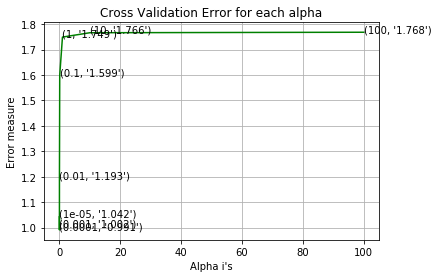

For values of best alpha =  0.0001 The train log loss is: 0.40341463543028316
For values of best alpha =  0.0001 The cross validation log loss is: 0.9906371128777
For values of best alpha =  0.0001 The test log loss is: 0.9678796376110629


In [102]:
# with simple features
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_m1, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_m1, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_m1)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_m1, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_m1, train_y)

predict_y = sig_clf.predict_proba(train_m1)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_m1)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_m1)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=sig_clf.classes_, eps=1e-15))

In [103]:
#Data preparation for ML models.


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

Log loss : 0.9906371128777
Number of mis-classified points : 0.3383458646616541
-------------------- Confusion matrix --------------------


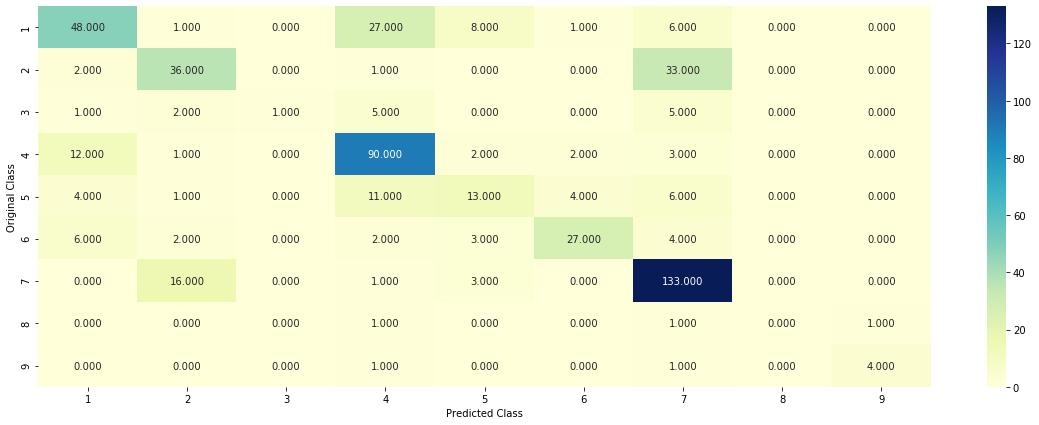

-------------------- Precision matrix (Columm Sum=1) --------------------


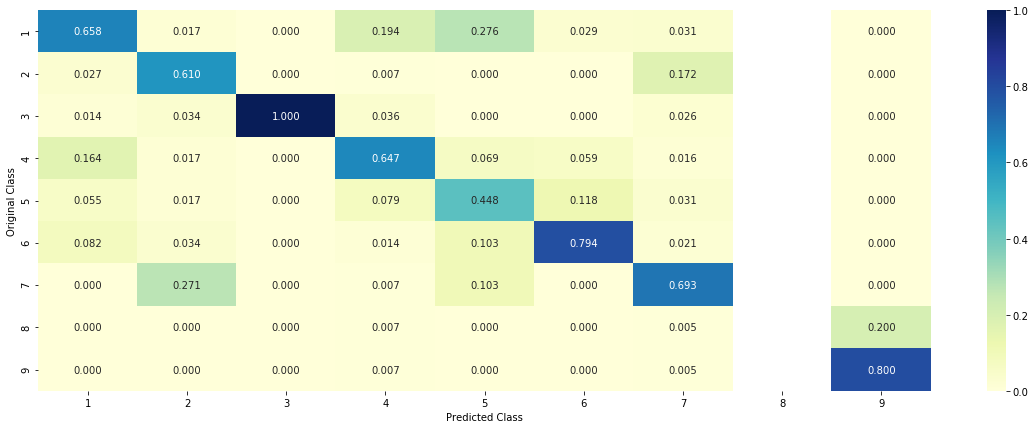

-------------------- Recall matrix (Row sum=1) --------------------


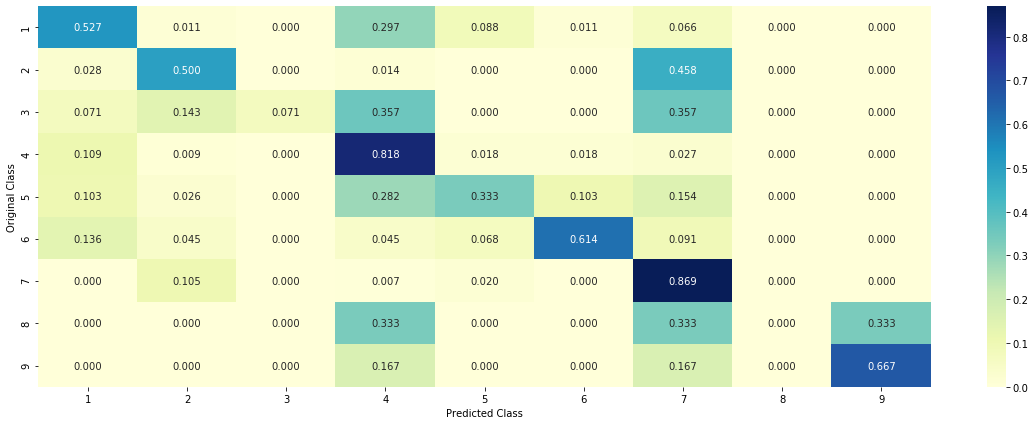

In [111]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_m1, train_y,cv_m1,cv_y, clf)

for C = 1e-05
Log Loss : 0.9875937395011316
for C = 0.0001
Log Loss : 0.951579219877717
for C = 0.001
Log Loss : 1.0081095960404023
for C = 0.01
Log Loss : 1.1583051328986718
for C = 0.1
Log Loss : 1.391450365710628
for C = 1
Log Loss : 1.495455728591203
for C = 10
Log Loss : 1.5092139226497103
for C = 100
Log Loss : 1.5108334895579465


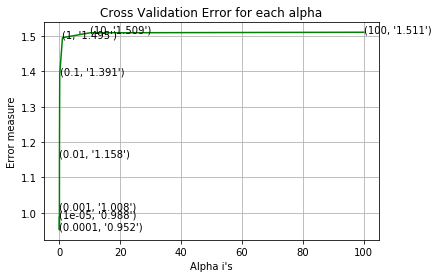

For values of best alpha =  0.0001 The train log loss is: 0.5753252839615339
For values of best alpha =  0.0001 The cross validation log loss is: 0.951579219877717
For values of best alpha =  0.0001 The test log loss is: 0.9237716047787213


In [105]:
# with advance features
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_m2, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_m2, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_m2)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_m2, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_m2, train_y)

predict_y = sig_clf.predict_proba(train_m2)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_m2)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_m2)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=sig_clf.classes_, eps=1e-15))

for C = 1e-05
Log Loss : 1.0437638464956183
for C = 0.0001
Log Loss : 0.9901024548384434
for C = 0.001
Log Loss : 1.0020825967617446
for C = 0.01
Log Loss : 1.1924888814188475
for C = 0.1
Log Loss : 1.6000008934010763
for C = 1
Log Loss : 1.750733510686438
for C = 10
Log Loss : 1.7679037830855717
for C = 100
Log Loss : 1.7698479097691842


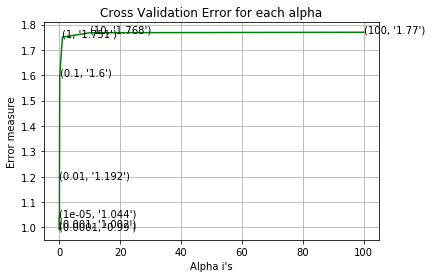

For values of best alpha =  0.0001 The train log loss is: 0.40228328318077944
For values of best alpha =  0.0001 The cross validation log loss is: 0.9901024548384434
For values of best alpha =  0.0001 The test log loss is: 0.9660016084901267


In [106]:
# with simple all features
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_m3, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_m3, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_m3)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_m3, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_m3, train_y)

predict_y = sig_clf.predict_proba(train_m3)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_m3)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_m3)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=sig_clf.classes_, eps=1e-15))

for C = 1e-05
Log Loss : 0.987365664620161
for C = 0.0001
Log Loss : 0.9486255043353754
for C = 0.001
Log Loss : 1.0066406638197314
for C = 0.01
Log Loss : 1.1574680464648728
for C = 0.1
Log Loss : 1.391532165281675
for C = 1
Log Loss : 1.4967551250757731
for C = 10
Log Loss : 1.5106803230551886
for C = 100
Log Loss : 1.5123165332228778


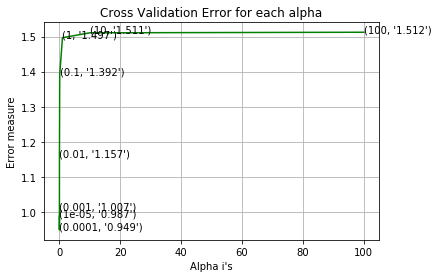

For values of best alpha =  0.0001 The train log loss is: 0.5740438968184022
For values of best alpha =  0.0001 The cross validation log loss is: 0.9486255043353754
For values of best alpha =  0.0001 The test log loss is: 0.921423057603431


In [107]:
# with advance all features
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_m4, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_m4, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_m4)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_m4, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_m4, train_y)

predict_y = sig_clf.predict_proba(train_m4)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_m4)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_m4)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [109]:
from prettytable import PrettyTable
 
columns = ["Feature Name", "Log Loss on Train Data", "Log Loss on CV Data", "Log Loss on Test Data"]
columns1 = ["Model Name", "Log Loss on Train Data", "Log Loss on CV Data", "Log Loss on Test Data"]


x = PrettyTable()
y = PrettyTable()
z = PrettyTable()

# Add Columns 
x.add_column(columns[0], ["Gene", "Variation", "Text w2v", "Text_count", "Text_len", "Text_density", "Text-TFIDF"]) 
x.add_column(columns[1], [0.985,0.679,1.831,1.810,1.810,1.831,0.629]) 
x.add_column(columns[2], [1.171,1.714,1.830,1.818,1.817,1.830,1.047]) 
x.add_column(columns[3], [1.240,1.714,1.830,1.850,1.845,1.830,1.058]) 

# Add Columns 
y.add_column(columns1[0], ["M1","M2","M3","M4"]) 
y.add_column(columns1[1], [0.403,0.575,0.402,0.574]) 
y.add_column(columns1[2], [0.990,0.951,0.990,0.948]) 
y.add_column(columns1[3], [0.967,0.923,0.966,0.921])

# Add Columns
z.add_column(columns[0], ["Gene", "Variation"])
z.add_column(columns[1], [0.999,0.835])
z.add_column(columns[2], [1.176,1.103])
z.add_column(columns[3], [1.248,1.047])

print('Univariate Analysis Report:\n',x)

print('Univariate Analysis Report on basis of Occurance of Unique features:\n',z)

print('Model Performance Report:\n',y)


Univariate Analysis Report:
 +--------------+------------------------+---------------------+-----------------------+
| Feature Name | Log Loss on Train Data | Log Loss on CV Data | Log Loss on Test Data |
+--------------+------------------------+---------------------+-----------------------+
|     Gene     |         0.985          |        1.171        |          1.24         |
|  Variation   |         0.679          |        1.714        |         1.714         |
|   Text w2v   |         1.831          |         1.83        |          1.83         |
|  Text_count  |          1.81          |        1.818        |          1.85         |
|   Text_len   |          1.81          |        1.817        |         1.845         |
| Text_density |         1.831          |         1.83        |          1.83         |
|  Text-TFIDF  |         0.629          |        1.047        |         1.058         |
+--------------+------------------------+---------------------+-----------------------+
Uni

# Conclusion

Logistic Regression has given best result on M4 dataset as compared to other model like MultinomialNB, KNN, SVM.

M4 dataset contains Gene, Variation feature on basis of occurance of unique feature, Text feature with TFIDF vectorizer and text_length, text_count,text_dendity feature.